# SPM12 scripting in a Jupyter notebook with an Octave kernel 

This is a [Jupyter notebook](https://jupyter.org/) running an [Octave kernel](https://github.com/Calysto/octave_kernel) on [Binder](https://mybinder.org/), which allows cloud-based computation using SPM12 and Matlab scripts. It is therefore a reproducible environment for fMRI analysis using [SPM12](https://www.fil.ion.ucl.ac.uk/spm/software/download/). Anyone with internet access can run this same code on the same data and should get the same results. It is not only a useful tool for tutorials and sharing work with collaborators, but specifically also as a means to share the data and methods underlying your scientific results.

For more information on how this service was set up, see [this blog post]().

The code below is based on a tutorial I previously shared in a [blog post](https://jsheunis.github.io/2018-06-28-spm12-matlab-scripting-tutorial-3/), and then later extended to a [reproducible environment with Code Ocean](https://jsheunis.github.io/2018-10-31-reproducible-fmri-codeocean/). This notebook achieves more or less the same using Binder, which is free for use and open source.

The instructions and code below will run through the process of performing several standard preprocessing and statistical analysis steps on a task-fMRI dataset using Matlab-based scripts and SPM12. We’re using an open and [freely available dataset](https://openneuro.org/datasets/ds000157/versions/00001) from [OpenNeuro](https://openneuro.org/), which includes functional and anatomical data for multiple subjects that took part in a “block design food and nonfood picture viewing task” (many thanks to the researchers for sharing their study data online!).

**Disclaimer**: these scripts (excluding external libraries) are for illustrative/tutorial purposes only. They have not been rigorously peer-reviewed and could contain errors. They also do not necessaroly include all steps that would typically form part of a robust analysis pipeline. Please use your own discretion.



## Data and experimental design

The data contains anatomical and functional images for multiple subjects from a task-based experiment about food temptation. More details can be found in the article (available through PubMed [here](https://www.ncbi.nlm.nih.gov/pubmed/23578759)), but the important thing for our purposes is that the experiment was a task-based design alternating between blocks of visual stimulus (photos of food and other objects shown to the subjects) and rest periods (where nothing was shown except for a small fixation cursor). Such a design allows us to apply statistical processes to the time series data (after appropriate preprocessing) in order to determine which voxels in the brain are more likely to be involved in visual processing. It is well known that the visual cortex is located at the posterior part of the human brain, so it will therefore be easy for us to know if our code fails miserably or whether it does what we expect it to do.

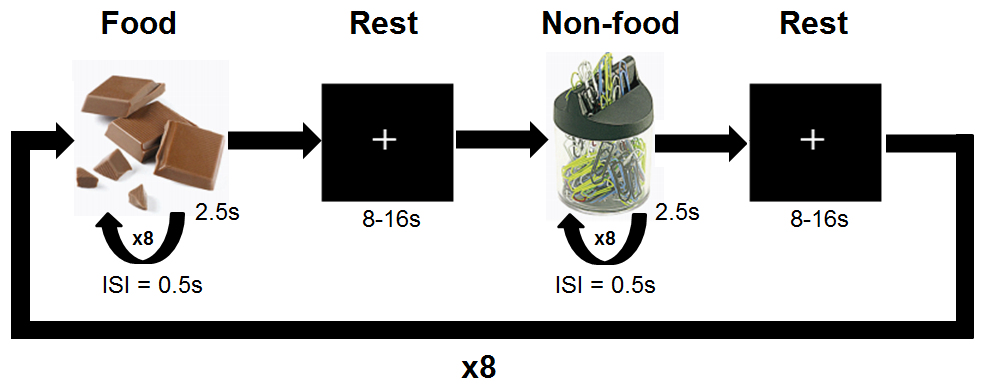

## STEP 1: Initialize directory structure for data inputs and outputs

If you are reading this on Binder, the necessary data and scripts would already have been downloaded to your compute environment hosted in the cloud. This includes the `ds000157-download` directory downloaded from OpenNeuro, which contains a single subject's data. It also includes Matlab scripts and libraries used below, such as directories `scripts`, `spm12`, and `dicm2nii`.

Run the code below in order to extract the required image files, move them to the correct locations, setup the desired directory structure, and initialize required variables.

In [1]:
% Preprocessed and analysed data will be in "results/" folder
data_dir = fullfile(getenv('HOME'),'ds000157-download');
spm_dir = fullfile(getenv('HOME'),'spm12');
results_dir = fullfile(getenv('HOME'),'results');
stats_dir = [results_dir filesep 'stats'];
processing_dir = [results_dir filesep 'preproc_data'];
if ~exist(stats_dir,'dir')
    mkdir(stats_dir);
end
if ~exist(processing_dir,'dir')
    mkdir(processing_dir);
end

% Initialize subject data; extract; copy to preprocessing folder

% count subjects in folder; can be expanded if downloaded more
dir_sub = dir(data_dir);
n_sub = length(dir_sub) - 2;

func_files = cell(n_sub,1);
anat_files = cell(n_sub,1);

for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end

    s_raw_fn = fullfile(data_dir, ['sub-' sub], 'anat', ['sub-' sub '_T1w.nii.gz']);
    if exist(s_raw_fn, 'file')
        out_fns = gunzip(s_raw_fn);
        s_fn = out_fns{1};
    else
        s_fn = strrep(s_raw_fn, '.gz', '');
    end
    f_raw_fn = fullfile(data_dir, ['sub-' sub], 'func', ['sub-' sub '_task-passiveimageviewing_bold.nii.gz']);
    if exist(f_raw_fn, 'file')
        out_fns = gunzip(f_raw_fn);
        f_fn = out_fns{1};
    else
        f_fn = strrep(f_raw_fn, '.gz', '');
    end

    % Create preprocessing subfolders
    anat_dir = fullfile(processing_dir, ['sub-' sub], 'anat'); 
    func_dir = fullfile(processing_dir, ['sub-' sub], 'func'); 
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    if ~exist(anat_dir, 'dir')
        mkdir(anat_dir);
    end
    if ~exist(func_dir, 'dir')
        mkdir(func_dir);
    end
    if ~exist(stats_dir, 'dir')
        mkdir(stats_dir);
    end
    
    % Copy extracted files to preprocessing subfolders
    anat_fn = fullfile(processing_dir, ['sub-' sub], 'anat', ['sub-' sub '_T1w.nii']);
    anat_files(i,1) = anat_fn; 
    func_fn = fullfile(processing_dir, ['sub-' sub], 'func', ['sub-' sub '_task-passiveimageviewing_bold.nii']);
    func_files(i,1) = func_fn; 
    if ~exist(anat_fn, 'file')
        copyfile(s_fn, anat_dir);
    end
    if ~exist(func_fn, 'file')
        copyfile(f_fn, func_dir);
    end
end
    % Initialize processing variables
fwhm = 6;  % mm
disp('Done')

Done


## STEP 2: Quick inspection of data

Let's load the anatomical data (using a derived form of `nii_viewer` from `dicm2nii`) to display the brain in three dimensions (saggital, coronal, axial).

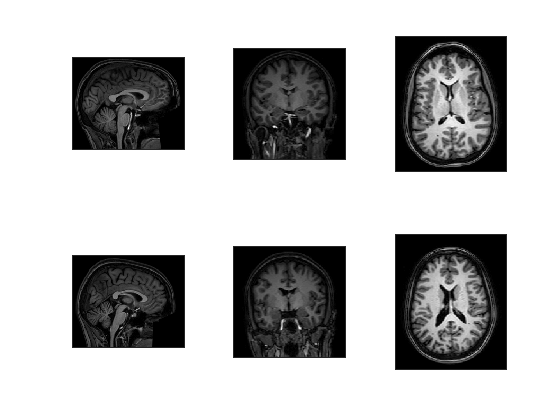

In [2]:
%% QUICK INSPECTION OF ANATOMICAL DATA
[p_anat, frm1, rg1, dim1] = fmrwhy_util_readNifti(char(anat_files(1,1)));
anat_3Dimg = p_anat.nii.img;

[Ni, Nj, Nk] = size(anat_3Dimg);
subplot(231); imagesc(rot90(squeeze(anat_3Dimg(round(Ni/2),35:245,1:Nk/2+30)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(232); imagesc(rot90(squeeze(anat_3Dimg(:,round(Nj/2),1:Nk/2+30)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(233); imagesc(rot90(squeeze(anat_3Dimg(:,35:245,round(Nk*0.35))))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

[p_anat, frm1, rg1, dim1] = fmrwhy_util_readNifti(char(anat_files(2,1)));
anat_3Dimg = p_anat.nii.img;

[Ni, Nj, Nk] = size(anat_3Dimg);
subplot(234); imagesc(rot90(squeeze(anat_3Dimg(round(Ni/2),35:245,1:Nk/2+30)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(235); imagesc(rot90(squeeze(anat_3Dimg(:,round(Nj/2),1:Nk/2+30)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(236); imagesc(rot90(squeeze(anat_3Dimg(:,35:245,round(Nk*0.35))))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

Let's load the function data (using a derived form of `nii_viewer` from `dicm2nii`) to display the brain in three dimensions (saggital, coronal, axial).

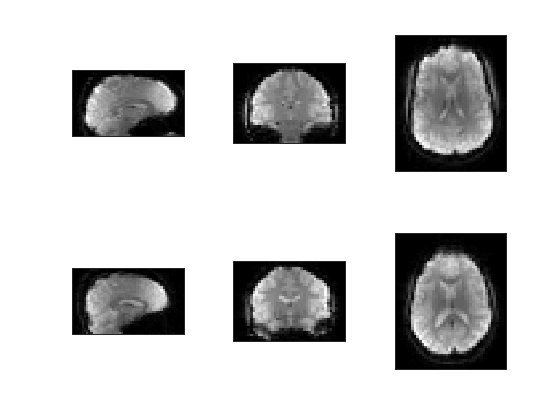

In [3]:
%% QUICK INSPECTION OF FUNCTIONAL DATA

[p_func, frm1, rg1, dim1] = fmrwhy_util_readNifti(char(func_files(1,1)));
func_4Dimg = p_func.nii.img;

[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(231); imagesc(rot90(squeeze(func_4Dimg(round(Ni/2),8:58,:,1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(232); imagesc(rot90(squeeze(func_4Dimg(12:53,round(Nj/2),:,1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(233); imagesc(rot90(squeeze(func_4Dimg(12:53,8:58,round(Nk/2),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

[p_func, frm1, rg1, dim1] = fmrwhy_util_readNifti(char(func_files(2,1)));
func_4Dimg = p_func.nii.img;

[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(234); imagesc(rot90(squeeze(func_4Dimg(round(Ni/2),8:58,:,1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(235); imagesc(rot90(squeeze(func_4Dimg(12:53,round(Nj/2),:,1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(236); imagesc(rot90(squeeze(func_4Dimg(12:53,8:58,round(Nk/2),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

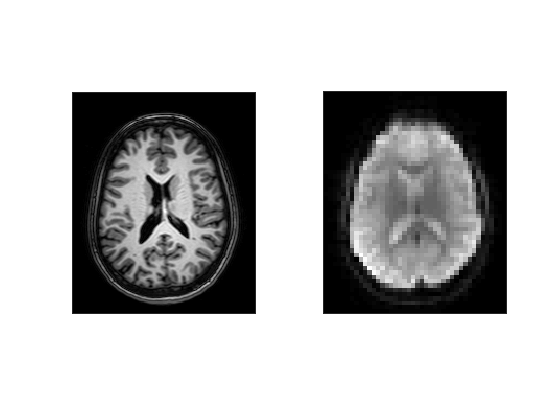

In [64]:
% Sub-01 anatomical and fucntional volumes

[Ni, Nj, Nk] = size(anat_3Dimg);
subplot(121); imagesc(rot90(anat_3Dimg(:,35:245,round(Nk*0.35)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]); 

[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(122); imagesc(rot90(func_4Dimg(12:53,8:58,round(Nk/2),1))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]); 

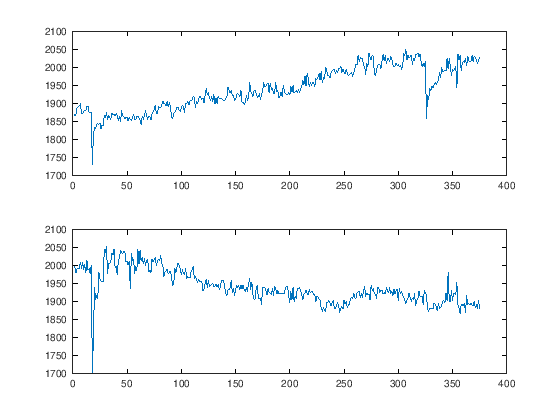

In [26]:
% Measure BOLD-timeseries of a random voxel from V1 (primary visual cortex) vs. random voxel from AC (anterior cingulate cortex)

[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(211); plot(func_4Dimg(37,15,round(Nk/2),:))
subplot(212); plot(func_4Dimg(Ni/2,47,round(Nk/2),:))

## STEP 3: Preprocessing

Preprocessing the data starts by calling `spm_standardPreproc_jsh` (located in the `scripts` directory). This function includes steps for:

1. Realigning all functional image volumes to the first functional image volume in the timeseries.
2. Coregistering the anatomical image to the first functional image volume in the timeseries.
3. Segmenting the coregistered anatomical image into tissue types (grey matter, white matter, cerebrospinal fluid).
4. Reslicing the coregistered anatomical image and all segmented tissue type images to the same resolution as the first functional image volume in the timeseries.
5. Smoothing the realigned functional timeseries data with a specified Gaussian kernel size.
6. Returning all results to a preproc_data structure.

This can take some time to run, perhaps around 15 minutes. Grab yourself a coffee...

In [2]:
% Preprocess structural and functional images (if not already)
% Calls function `spm_standardPreproc_jsh`
for i = 1:n_sub
    [d, f, e] = fileparts(char(anat_files(i,1)));
    [d1, f1, e1] = fileparts(char(func_files(i,1)));
    if exist([d filesep 'rc1' f e], 'file')
        disp('...preproc already done, saving variables...')
        %preproc_data(i) = struct;
        % Structural filenames
        preproc_data(i).forward_transformation = [d filesep 'y_' f e];
        preproc_data(i).inverse_transformation = [d filesep 'iy_' f e];
        preproc_data(i).gm_fn = [d filesep 'c1' f e];
        preproc_data(i).wm_fn = [d filesep 'c2' f e];
        preproc_data(i).csf_fn = [d filesep 'c3' f e];
        preproc_data(i).bone_fn = [d filesep 'c4' f e];
        preproc_data(i).soft_fn = [d filesep 'c5' f e];
        preproc_data(i).air_fn = [d filesep 'c6' f e];
        preproc_data(i).rstructural_fn = [d filesep 'r' f e];
        preproc_data(i).rgm_fn = [d filesep 'rc1' f e];
        preproc_data(i).rwm_fn = [d filesep 'rc2' f e];
        preproc_data(i).rcsf_fn = [d filesep 'rc3' f e];
        preproc_data(i).rbone_fn = [d filesep 'rc4' f e];
        preproc_data(i).rsoft_fn = [d filesep 'rc5' f e];
        preproc_data(i).rair_fn = [d filesep 'rc6' f e];
        % Functional filenames
        preproc_data(i).rfunctional_fn = [d1 filesep 'r' f1 e1];
        preproc_data(i).srfunctional_fn = [d1 filesep 'sr' f1 e1];
        preproc_data(i).mp_fn = [d1 filesep 'rp_' f1 '.txt'];
        preproc_data(i).MP = load(preproc_data.mp_fn);
    else
        disp('...running preprocessing batch jobs...')
        preproc_data(i) = spm_standardPreproc_jsh(char(func_files(i,1)), char(anat_files(i,1)), fwhm, spm_dir);
    end
end

...running preprocessing batch jobs...
Step 1 -- Realign all volumes to first functional volume


------------------------------------------------------------------------
11-Mar-2021 16:26:58 - Running job #1
------------------------------------------------------------------------
11-Mar-2021 16:26:58 - Running 'Realign: Estimate & Reslice'

SPM12: spm_realign (v7141)                         16:26:58 - 11/03/2021
Completed                               :          16:28:08 - 11/03/2021

SPM12: spm_reslice (v7141)                         16:28:08 - 11/03/2021
Completed                               :          16:28:52 - 11/03/2021
11-Mar-2021 16:28:52 - Done    'Realign: Estimate & Reslice'
11-Mar-2021 16:28:52 - Done

Step 1 - Done!
Step 2 -- Coregister structural image to first dynamic image


------------------------------------------------------------------------
11-Mar-2021 16:29:06 - Running job #1
------------------------------------------------------------------------
11-Mar-2021

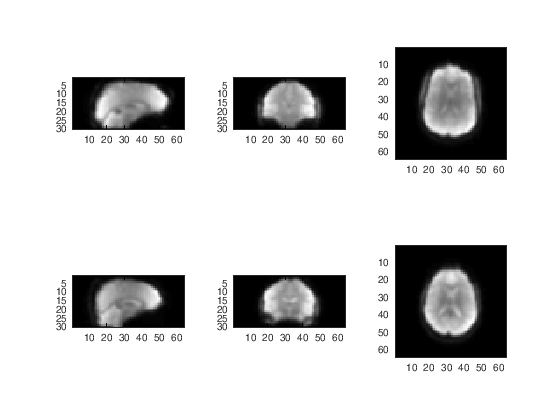

In [26]:
% Display smoothed out images

smooth_fn = spm_vol(fullfile(getenv('HOME'),'results','preproc_data','sub-01','func','srsub-01_task-passiveimageviewing_bold.nii'));
A = spm_read_vols(smooth_fn);
[Ni, Nj, Nk, Nt] = size(A);
subplot(231); imagesc(rot90(squeeze(A(round(Ni/2),:,:,1)))); colormap gray; axis image
subplot(232); imagesc(rot90(squeeze(A(:,round(Nj/2),:,1)))); colormap gray; axis image
subplot(233); imagesc(rot90(squeeze(A(:,:,round(Nk/2),1)))); colormap gray; axis image

smooth_fn = spm_vol(fullfile(getenv('HOME'),'results','preproc_data','sub-02','func','srsub-02_task-passiveimageviewing_bold.nii'));
A = spm_read_vols(smooth_fn);
[Ni, Nj, Nk, Nt] = size(A);
subplot(234); imagesc(rot90(squeeze(A(round(Ni/2),:,:,1)))); colormap gray; axis image
subplot(235); imagesc(rot90(squeeze(A(:,round(Nj/2),:,1)))); colormap gray; axis image
subplot(236); imagesc(rot90(squeeze(A(:,:,round(Nk/2),1)))); colormap gray; axis image

## STEP 4: Create 1st level statistical design

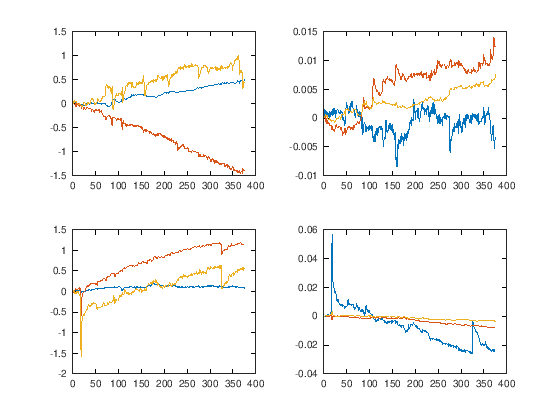

In [3]:
% Plot motion parameters

m_par = fullfile(getenv('HOME'),'results','preproc_data','sub-01','func','rp_sub-01_task-passiveimageviewing_bold.txt');
motion = load(m_par);
subplot(221); plot(motion(:,1:3)) % rotational x,y,z
subplot(222); plot(motion(:,4:6)) % traslational raw, pitch, yaw

m_par = fullfile(getenv('HOME'),'results','preproc_data','sub-02','func','rp_sub-02_task-passiveimageviewing_bold.txt');
motion = load(m_par);
subplot(223); plot(motion(:,1:3)) % rotational x,y,z
subplot(224); plot(motion(:,4:6)) % traslational raw, pitch, yaw


Here we create the first level statistical design to analyse the preprocessed data. This is done with `spm_specify1stlevel_jsh`.

We set the timing units as seconds because that is how we want to specify the task stimulus onsets and durations (the other unit option is ‘scans’). The repetition time is set to 1.6 seconds, as specified in the `task-passiveimageviewing_bold.json` file supplied together with the dataset. The task stimulus onsets and durations are given in the `sub-01_task-passiveimageviewing_events.tsv` file supplied with the `sub-01` data. The `.tsv` file also gives the type of stimulus, either food or non-food pictures. For this exercise, we are not interested in the differences in brain responses between food and non-food picture viewing, rather we just want to see which voxels in the brain are likely involved in any type of picture viewing experience vs only looking at a black screen with a cursor. This is why we specified vectors of all onset times and durations (except for the break period) for the respective parameters. Finally we also supply the text file with the movement parameters (`preproc_data.mp_fn`; resulting from the 6 DOF rigid body transformations during the realignment step) to be included as regressors in the design matrix.

Can not initialise pmod value(s): job is not a struct.
Can not initialise regress value(s): job is not a struct.
Can not initialise fact value(s): job is not a struct.


------------------------------------------------------------------------
11-Mar-2021 17:01:27 - Running job #1
------------------------------------------------------------------------
11-Mar-2021 17:01:27 - Running 'fMRI model specification'

SPM12: spm_fMRI_design (v7739)                     17:01:28 - 11/03/2021
Saving fMRI design                      :               ...SPM.mat saved

SPM12: spm_fmri_spm_ui (v7738)                     17:01:28 - 11/03/2021
Mapping files                           :                        ...done
Calculating globals                     :                        ...done
Saving SPM configuration                :               ...SPM.mat saved
Saving SPM configuration                :               ...SPM.mat saved
Completed                               :          17:01:37 - 11/03/2021
11

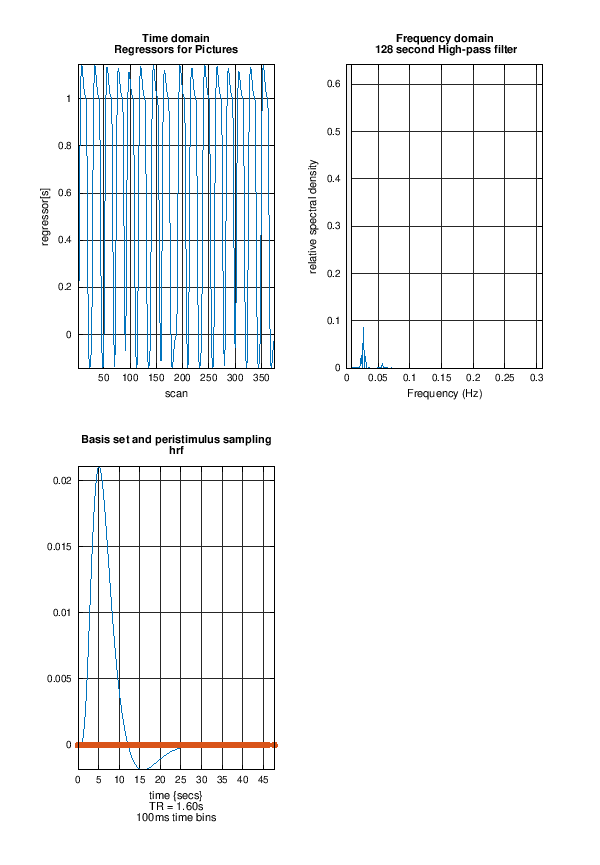

In [5]:
% Set up statistical design parameters, based on task data

    sess_params = struct;
    sess_params.timing_units = 'secs';
    sess_params.timing_RT = 1.6;
    sess_params.cond_name = 'Pictures';
    sess_params.cond_onset = [0; 40.1; 77.2; 111.3; 143.3; 179.4; 218.5; 251.5; 299.6; 334.7; 374.8; 411.9; 445.9; 478.0; 514.1; 553.2];
    sess_params.cond_duration = [24.1000; 24.06; 24.07; 24.06; 24.06; 24.07; 24.04; 24.06; 24.07; 24.10; 24.06; 24.06; 24.09; 24.09; 24.06; 24.07];
    
for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end
    
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    
    % Call script to set up design
    spm_specify1stlevel_jsh(stats_dir, preproc_data(i).srfunctional_fn, preproc_data(i).mp_fn, sess_params);
    
    % Display/explore design matrix 
    load([stats_dir filesep 'SPM.mat']);
    spm_DesRep('fMRIDesMtx',SPM,1,1)
    saveas(gcf, [processing_dir filesep 'des_mat.png'])
end

## STEP 5: Estimate the model

Estimating the model fit, i.e. running the general linear model with the specified design. This is done with `spm_estimateModel_jsh`.

In [7]:
for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end
    
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    spm_estimateModel_jsh(stats_dir)
    disp('Subject')
end
disp('Done')



------------------------------------------------------------------------
11-Mar-2021 17:05:20 - Running job #1
------------------------------------------------------------------------
11-Mar-2021 17:05:21 - Running 'Model estimation'

SPM12: spm_spm (v7738)                             17:05:21 - 11/03/2021

SPM12: spm_est_non_sphericity (v7577)              17:05:25 - 11/03/2021
Chunk   1/1                             :                  ...processi                       ...done
Temporal non-sphericity (18704 voxels)  :             ...ReML estimation
  ReML Block 1                
  ReML Iteration 1                      :        ...1.858685e+02 [+4.25]
  ReML Iteration 2                      :        ...1.730852e+02 [+4.50]
  ReML Iteration 3                      :        ...2.305373e+00 [+4.75]
  ReML Iteration 4                      :        ...2.407820e-01 [+5.00]
  ReML Iteration 5                      :        ...2.278930e-02 [+5.25]

SPM12: spm_spm (v7738)                       

## STEP 6: Setup the task contrast

Here we create the task contrast used as input for the statistical testing. This is done with `spm_setupTaskContrast_jsh`.

In [14]:
[Ntt, Nregr] = size(SPM.xX.X);
contrast_params = struct;
contrast_params.weights = zeros(1, Nregr); 
contrast_params.weights(1) = 1;
contrast_params.name = 'Picture viewing';

for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end
    
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    spm_setupTaskContrast_jsh(stats_dir, contrast_params)
    disp('Subject')
end
disp('Done')



------------------------------------------------------------------------
11-Mar-2021 17:10:37 - Running job #1
------------------------------------------------------------------------
11-Mar-2021 17:10:37 - Running 'Contrast Manager'

SPM12: spm_contrasts.m                             17:10:37 - 11/03/2021
Contrasts folder                        :    ./preproc_data/sub-01/stats
	contrast image  1               :                   ...computi       ...written con_0001.nii
	spm{T} image  1                 :                   ...computi      ...written spmT_0001.nii
	Saving SPM.mat                  :                     ...writi              ...SPM.mat saved
Completed                               :          17:10:49 - 11/03/2021
11-Mar-2021 17:10:49 - Done    'Contrast Manager'
11-Mar-2021 17:10:49 - Done

Subject


------------------------------------------------------------------------
11-Mar-2021 17:11:08 - Running job #1
--------------------------------------------------------------

## STEP 7: Generate results

Finally, we apply statistical tests and some correction factors to generate a 3D map of thresholded t-values (resulting from t-tests), which indicate voxels that are likely to be involved in the task. This is done with ``
`spm_runResults_jsh`.

In [15]:
spm_runResults_jsh(stats_dir)



------------------------------------------------------------------------
11-Mar-2021 17:12:27 - Running job #1
------------------------------------------------------------------------
11-Mar-2021 17:12:27 - Running 'Results Report'
	SPM computation                 :                ...initialisi           ...height thresho           ...extent thresho                       ...done


Statistics: p-values adjusted for search volume
set	set	cluster	cluster	cluster	cluster	peak	peak	peak	peak	peak	
p	c	p(FWE-corr)	p(FDR-corr)	equivk	p(unc)	p(FWE-corr)	p(FDR-corr)	T	equivZ	p(unc)	x,y,z {mm}
--------------------------------------------------------------------------------
0.000	33	0.000	0.000	559	0.000	0.000	0.000	 24.06	  Inf	0.000	-22 -64  16 	
						0.000	0.000	 20.01	  Inf	0.000	-30 -48  -0 	
						0.000	0.000	 19.70	  Inf	0.000	-22 -60   4 	
		0.000	0.000	540	0.000	0.000	0.000	 22.67	  Inf	0.000	 26 -60   8 	
						0.000	0.000	 20.76	  Inf	0.000	 38 -56  20 	
						0.000	0.000	 20.54	  I

## STEP 8: Explore and visualise results

This part is still to be expanded...

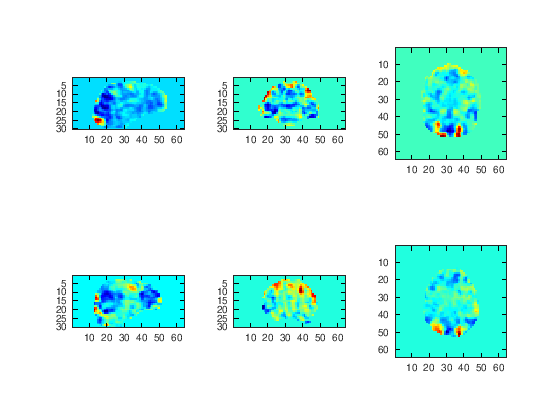

In [21]:
% Display contrast image

con_fn = spm_vol(fullfile(processing_dir, 'sub-01', 'stats', 'spmT_0001.nii'));
contrast = spm_read_vols(con_fn);
[Ni, Nj, Nk] = size(contrast);
subplot(231); imagesc(rot90(squeeze(contrast(round(Ni/2+2),:,:,1)))); colormap jet; axis image %watch out, plotting may include all points in plot changing colormap limits
subplot(232); imagesc(rot90(squeeze(contrast(:,round(Nj/2),:,1)))); colormap jet; axis image
subplot(233); imagesc(rot90(squeeze(contrast(:,:,round(Nk/2),1)))); colormap jet; axis image

con_fn = spm_vol(fullfile(processing_dir, 'sub-02', 'stats', 'spmT_0001.nii'));
contrast = spm_read_vols(con_fn);
[Ni, Nj, Nk] = size(contrast);
subplot(234); imagesc(rot90(squeeze(contrast(round(Ni/2+2),:,:,1)))); colormap jet; axis image %watch out, plotting may include all points in plot changing colormap limits
subplot(235); imagesc(rot90(squeeze(contrast(:,round(Nj/2),:,1)))); colormap jet; axis image
subplot(236); imagesc(rot90(squeeze(contrast(:,:,round(Nk/2),1)))); colormap jet; axis image